<img src="https://cdn-images-1.medium.com/max/2400/1*njhuKpqziXtVFjykPV3yoQ.jpeg" style="float: left; margin: 20px; height: 100px" >

# NLP Classification using Twitter API


_@kbengtsonwong_

---

_This notebook consisted my final project for an undergraduate statistical learning course.  I demonstrate that it is possible to use the text from tweets, obscuring the author, to build a classifier that predicts the tweet author._


### Configuring API Access

In [1]:
import twitter, re, datetime, pandas as pd, numpy as np

# Developer keys, which have since been regenerated 
twitter_keys = {
    'consumer_key':        'jGYCEXSquQ8plbOcOayN1Yo6D',
    'consumer_secret':     'jeJnGi78PLP3YVdxJxFIhCC3bFvqAMzBzPmm5WjVwJBxWntBNJ',
    'access_token_key':    '244392779-bf5KNaTsmCmIS7NGYXfEvx6sE9MY3DkTE1Lla6cI',
    'access_token_secret': 'jwt5GIqGTOzRyD0CDFYmUl7JLdztg8TI1IKMS4QaPgoEA'
}

# Builds API access dictionary for later use
api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret']
)


In [2]:
# Defines a TweetMiner class that can be initialized with the twitter keys and has a method to return user tweet data
class TweetMiner(object):

    result_limit    =   20    
    api             =   False
    data            =   []
    
    def __init__(self, keys_dict, api, result_limit = 20):
        
        self.api = api
        self.twitter_keys = keys_dict
        
        self.result_limit = result_limit
        

    def mine_user_tweets(self, user, mine_rewteets=False, max_pages=5):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        # iterate through pages of tweets
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id - 1)        
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit)
                
            for item in statuses:

                mined = {
                    'tweet_id':        item.id,
                    'handle':          item.user.name,
                    'retweet_count':   item.retweet_count,
                    'text':            item.text,
                    'mined_at':        datetime.datetime.now(),
                    'created_at':      item.created_at,
                }
                
                last_tweet_id = item.id
                
                # only add original tweets, not retweets
                if "RT @" not in mined['text']:
                    data.append(mined)
                
            page += 1
            
        return data

---
<img src="https://snag.gy/RNAEgP.jpg" width="600">




**Donald Trump and Bernie Sanders are vocal political figures who tweet often with different styles and topics...**

_Can we train a statistical model to predict who tweeted what?_

### Loading Data using Twitter API

In [3]:
# Instantiates a TweetMiner object
tweet_miner = TweetMiner(twitter_keys, api)

# Uses the TweetMiner to load tweets from Donald Trump and Bernie Sanders' twitter accounts
trump_tweets = tweet_miner.mine_user_tweets(user='realDonaldTrump',max_pages=75)
bernie_tweets = tweet_miner.mine_user_tweets(user='BernieSanders',max_pages=75)

In [4]:
# Example Trump tweet:
trump_tweets[100]

{'created_at': u'Sun Jul 21 20:33:30 +0000 2019',
 'handle': u'Donald J. Trump',
 'mined_at': datetime.datetime(2019, 7, 26, 15, 45, 21, 501453),
 'retweet_count': 17362,
 'text': u'....Most importantly you have led Israel with a commitment to the values of democracy, freedom, and equal opportuni\u2026 https://t.co/RYyS1fHnIo',
 'tweet_id': 1153040324241088512}

In [5]:
# Example Bernie tweet:
bernie_tweets[100]

{'created_at': u'Wed Jul 17 20:25:47 +0000 2019',
 'handle': u'Bernie Sanders',
 'mined_at': datetime.datetime(2019, 7, 26, 15, 47, 20, 881799),
 'retweet_count': 605,
 'text': u'The current debate over #MedicareForAll really has nothing to do with health care.\n\nIt has everything to do with gr\u2026 https://t.co/J1BqMwHBPa',
 'tweet_id': 1151588831566671879}

In [6]:
# Combines both Trump and Sanders mined tweets (lists of dictionaries) into a single dataframe
df = pd.DataFrame(trump_tweets + bernie_tweets)

### Data Exploration & Preprocessing

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083 entries, 0 to 2082
Data columns (total 6 columns):
created_at       2083 non-null object
handle           2083 non-null object
mined_at         2083 non-null datetime64[ns]
retweet_count    2083 non-null int64
text             2083 non-null object
tweet_id         2083 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.1 MB


In [8]:
df.head()

,created_at,handle,mined_at,retweet_count,text,tweet_id
0,Fri Jul 26 22:37:00 +0000 2019,Donald J. Trump,2019-07-26 15:45:10.171499,4224,Wow! Big VICTORY on the Wall. The United State...,1154883345546928128
1,Fri Jul 26 22:18:26 +0000 2019,Donald J. Trump,2019-07-26 15:45:10.171512,3426,https://t.co/nr9bDv3Ktq,1154878670739300358
2,Fri Jul 26 21:59:27 +0000 2019,Donald J. Trump,2019-07-26 15:45:10.171515,3923,“@DHSgov @DHSMcAleenan Puts Guatemalan Migrant...,1154873893204713479
3,Fri Jul 26 18:29:22 +0000 2019,Donald J. Trump,2019-07-26 15:45:10.171521,14492,The WTO is BROKEN when the world’s RICHEST cou...,1154821023197474817
4,Fri Jul 26 18:17:05 +0000 2019,Donald J. Trump,2019-07-26 15:45:10.171525,7770,Great morning at the Pentagon yesterday. Congr...,1154817932540690432


In [9]:
df.tail()

,created_at,handle,mined_at,retweet_count,text,tweet_id
2078,Mon Apr 08 15:46:40 +0000 2019,Bernie Sanders,2019-07-26 15:49:25.853889,1325,"Meanwhile, one in four Americans skip health c...",1115279801592446977
2079,Mon Apr 08 01:47:20 +0000 2019,Bernie Sanders,2019-07-26 15:49:25.853892,3181,Another horrific attack in the Saudi-led war i...,1115068576162095104
2080,Sun Apr 07 20:13:39 +0000 2019,Bernie Sanders,2019-07-26 15:49:25.853896,346,"Join our town meeting in Malcom, Iowa! https:/...",1114984604656488448
2081,Sun Apr 07 19:22:00 +0000 2019,Bernie Sanders,2019-07-26 15:49:25.853899,2250,It’s absurd that we have to say this in Americ...,1114971604700758017
2082,Sun Apr 07 18:13:14 +0000 2019,Bernie Sanders,2019-07-26 15:49:25.853905,1576,We will no longer tolerate the situation in wh...,1114954298318782464


In [10]:
# Examining the text data
df['text']

0       Wow! Big VICTORY on the Wall. The United State...
1                                 https://t.co/nr9bDv3Ktq
2       “@DHSgov @DHSMcAleenan Puts Guatemalan Migrant...
3       The WTO is BROKEN when the world’s RICHEST cou...
4       Great morning at the Pentagon yesterday. Congr...
5       France just put a digital tax on our great Ame...
6       Apple will not be given Tariff waiver, or reli...
7       Q2 GDP Up 2.1% Not bad considering we have the...
8       There may or may not be National Security conc...
9       ....the fact that I have gone through a three ...
10      .@FoxNews is at it again. So different from wh...
11      “Taken for Granted,” a wonderful new book by G...
12      “Intelligence Community disappointed Mueller d...
13      I am pleased to announce the House has passed ...
14      Give A$AP Rocky his FREEDOM. We do so much for...
15      Very disappointed in Prime Minister Stefan Löf...
16      ...What took place was completely unacceptable...
17      We lov

In [11]:
# Using the Textacy package to do more comprehensive text-cleaning
from textacy.preprocess import preprocess_text

tweet_text = df['text'].values
clean_text = [preprocess_text(x, fix_unicode=True, lowercase=True, transliterate=False,
                              no_urls=True, no_emails=True, no_phone_numbers=True, no_currency_symbols=True,
                              no_punct=True, no_accents=True)
              for x in tweet_text]

In [12]:
# Example pre and post processing
print(df['text'][1])
print(clean_text[1])

https://t.co/nr9bDv3Ktq
url


In [13]:
# Another example pre and post processing
print(df['text'][100])
print(clean_text[100])

....Most importantly you have led Israel with a commitment to the values of democracy, freedom, and equal opportuni… https://t.co/RYyS1fHnIo
most importantly you have led israel with a commitment to the values of democracy freedom and equal opportuni url


**tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Using TfidfVectorizer to find ngrams where n = (2,3)
vect = TfidfVectorizer(ngram_range=(2,3),stop_words='english')

# Pulls all of Trumps tweet texts into one huge string
summaries = "".join(df['text'][df['handle']=='Donald J. Trump'])
trump_ngrams_summaries = vect.build_analyzer()(summaries)

# Displaying the 30 most common 2,3-ngrams in Trump's tweets
trump_mc = Counter(trump_ngrams_summaries).most_common(30)
trump_mc

[(u'united states', 40),
 (u'fake news', 30),
 (u'witch hunt', 17),
 (u'mueller report', 16),
 (u'news media', 16),
 (u'new york', 15),
 (u'white house', 14),
 (u'southern border', 14),
 (u'president trump', 13),
 (u'prime minister', 13),
 (u'fake news media', 12),
 (u'america great', 11),
 (u'robert mueller', 11),
 (u'great state', 10),
 (u'great honor', 9),
 (u'crooked hillary', 9),
 (u'great job', 9),
 (u'radical left', 9),
 (u'supreme court', 8),
 (u'north carolina', 8),
 (u'china https', 7),
 (u'pleased announce', 7),
 (u'maga https', 7),
 (u'york times', 7),
 (u'deal mexico', 7),
 (u'new york times', 7),
 (u'thank https', 7),
 (u'billion dollars', 6),
 (u'republican party', 6),
 (u'attorney general', 6)]

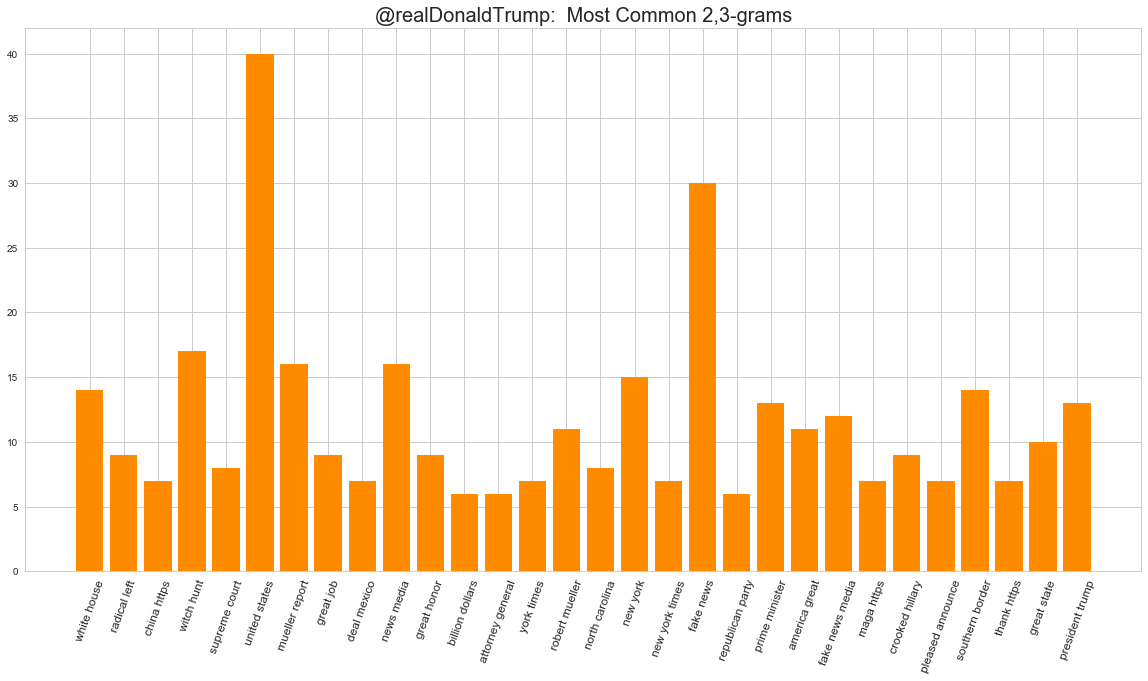

In [15]:
# Plotting features
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

D = dict(trump_mc)

plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center',color='darkorange')
plt.xticks(range(len(D)), list(D.keys()),rotation=70,size=12)
plt.title("@realDonaldTrump:  Most Common 2,3-grams",size=20)
plt.show()

In [16]:
# Pulls all of Sanders tweet text's into one giant string
summaries = "".join(df['text'][df['handle']=='Bernie Sanders'])
bernie_ngrams_summaries = vect.build_analyzer()(summaries)

# Displaying the 30 most common 2,3-ngrams in Sanders' tweets
bernie_mc = Counter(bernie_ngrams_summaries).most_common(30)
bernie_mc

[(u'health care', 56),
 (u'donald trump', 31),
 (u'minimum wage', 19),
 (u'wall street', 19),
 (u'united states', 18),
 (u'health insurance', 17),
 (u'student debt', 14),
 (u'years ago', 13),
 (u'climate change', 13),
 (u'american people', 12),
 (u'working people', 12),
 (u'tax breaks', 11),
 (u'white house', 11),
 (u'south carolina', 11),
 (u'living wage', 10),
 (u'th https', 10),
 (u'political revolution', 10),
 (u'middle ground', 10),
 (u'drug companies', 9),
 (u'town hall', 9),
 (u'people https', 9),
 (u'union movement', 9),
 (u'join live', 8),
 (u'15 minimum', 8),
 (u'economic rights', 8),
 (u'young people', 8),
 (u'15 hour', 8),
 (u'country https', 8),
 (u'insurance companies', 8),
 (u'major country', 8)]

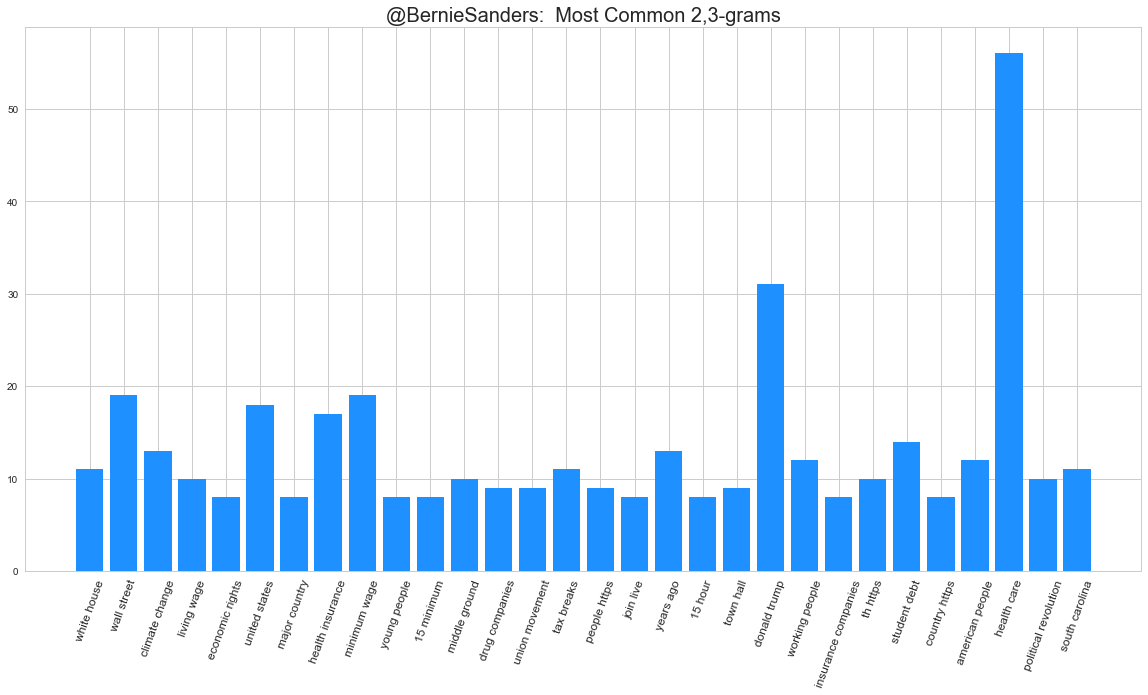

In [17]:
D = dict(bernie_mc)

plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center',color='dodgerblue')
plt.xticks(range(len(D)), list(D.keys()),rotation=70,size=12)
plt.title("@BernieSanders:  Most Common 2,3-grams",size=20)
plt.show()

In [18]:
# Combined Trump & Sanders tweets 
summaries = "".join(clean_text)
ngrams_summaries = vect.build_analyzer()(summaries)

Counter(ngrams_summaries).most_common(30)

[(u'health care', 56),
 (u'united states', 54),
 (u'donald trump', 33),
 (u'fake news', 29),
 (u'white house', 25),
 (u'new york', 21),
 (u'wall street', 20),
 (u'minimum wage', 19),
 (u'years ago', 18),
 (u'health insurance', 17),
 (u'urldonald trump', 15),
 (u'mueller report', 15),
 (u'witch hunt', 15),
 (u'news media', 15),
 (u'president trump', 14),
 (u'student debt', 14),
 (u'southern border', 14),
 (u'prime minister', 13),
 (u'climate change', 13),
 (u'american people', 13),
 (u'working people', 13),
 (u'robert mueller', 11),
 (u'tax breaks', 11),
 (u'south carolina', 11),
 (u'urlwe need', 11),
 (u'supreme court', 11),
 (u'fake news media', 11),
 (u'urlthe democrats', 11),
 (u'urli stand', 11),
 (u'drug companies', 10)]

In [19]:
# Initializing a tf-idf vectorizer to be used for all subsequent modeling
vect = TfidfVectorizer(ngram_range=(1,3),stop_words='english', max_features=2500)

# Creating X matrix -- a vectorized version of the clean text
X = vect.fit_transform(clean_text).todense()

print(X.shape)

(2083, 2500)


In [20]:
# Looking at the unique handles from the original data
df['handle'].unique()

array([u'Donald J. Trump', u'Bernie Sanders'], dtype=object)

In [21]:
# Creating y matrix -- 0 if the tweet is by Trump, 1 if Bernie
y = df['handle'].map(lambda x: 0 if x == 'Donald J. Trump' else 1).values

---
<img src="https://cdn1.alphr.com/sites/alphr/files/styles/16x9_640/public/2017/08/this_crowdfund_wants_to_buy_twitter_to_stop_trump.jpg?itok=vr6vrzO8&timestamp=1503561835">

## Binary Classification: Predicting Author from Vectorized Text

In [22]:
from sklearn.linear_model import LogisticRegression

# Setup logistic regression (lazy way)
logistic = LogisticRegression()
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
from sklearn.model_selection import cross_val_score

# Cross-validating the accuracy
accuracies = cross_val_score(LogisticRegression(), X, y, cv=10)

print "10-fold Cross Validated Accuracies:"
print accuracies
print "\nAverage: " + str(np.mean(accuracies))

10-fold Cross Validated Accuracies:
[ 0.90909091  0.8708134   0.9138756   0.88038278  0.875       0.87980769
  0.90384615  0.92307692  0.87019231  0.91304348]

Average: 0.893912923461


In [24]:
# Trying new methods —— Random Forest and a K-nearest Neighbor Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=200, verbose=1)
knn = KNeighborsClassifier(n_neighbors=7)

rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.6s finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [25]:
# Random forest and k-nearest neighbor accuracy scores:
print 'RF:', rf.score(X_test, y_test)
print 'KNN:', knn.score(X_test, y_test)

RF:

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished


 0.8752
KNN: 0.88


In [26]:
# Testing the model with new text from Trump and Sanders respectively
source_test = [
    
    "Despite the tremendous success that I have had as President, including perhaps the greatest \
    ECONOMY and most successful first two years of any President in history, they have stollen \
    two years of my (our) Presidency (Collusion Delusion) that we will never be able to get back....",
    
    "Demanding that the wealthy and the powerful start paying their fair share of taxes \
    that's exactly what the American people want."
]

# Applying the same transformation
Xtest = vect.transform(source_test).todense()

logistic.predict_proba(Xtest)

# 1st Tweet: %Trump  % Sanders
# 2nd Tweet: %Trump  % Sanders

array([[ 0.76404563,  0.23595437],
       [ 0.19338509,  0.80661491]])

In [27]:
rf.predict_proba(Xtest)

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


array([[ 0.79 ,  0.21 ],
       [ 0.325,  0.675]])

In [28]:
knn.predict_proba(Xtest)

array([[ 1.        ,  0.        ],
       [ 0.42857143,  0.57142857]])

In [29]:
# Cross-validating random forest accuracy 
accuracies = cross_val_score(rf, X, y, cv=10)

print "10-fold Cross Validated Accuracies:"
print accuracies
print "\nAverage: " + str(np.mean(accuracies))

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]

10-fold Cross Validated Accuracies:
[ 0.89952153  0.84210526  0.8708134   0.83732057  0.87019231  0.83653846
  0.875       0.88461538  0.85096154  0.87439614]

Average: 0.864146459312


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


In [30]:
# Cross-validating knn accuracy 
accuracies = cross_val_score(knn, X, y, cv=10)

print "10-fold Cross Validated Accuracies:"
print accuracies
print "\nAverage: " + str(np.mean(accuracies))

10-fold Cross Validated Accuracies:
[ 0.83732057  0.81818182  0.83253589  0.83253589  0.78365385  0.81730769
  0.85576923  0.84615385  0.84134615  0.85024155]

Average: 0.83150464778


In [31]:
# This cell contains my custom implementation of Logistic Regression using SGD:

from __future__ import division

# Evaluate the current value of the objective function
def eval_f(X,Y,numClass,beta):
    
    numRows, numCols = X.shape
    numClasses, numCols = beta.shape
  
    cost = 0
    
    for i in range(numRows):
        
        # Compute the denominator first
        denominator = 0
        for k in range(numClass):
            denominator += np.exp(X[i].dot(beta[k]))
        
        for k in range(numClass):
            cost += Y[i][k] * np.log( np.exp(X[i].dot(beta[k])) / denominator )  
     
    return -cost


# Returns a gradient matrix the same shape as beta for training example i
def gradient(X,Y,beta,numClass,example_i):
    
    numRows, numCols = X.shape
    P = np.zeros(numClass)
    
    denominator = 0
    for k in range(numClass):
        denominator += np.exp(X[example_i].dot(beta[k]))
            
    for k in range(numClass):
        P[k] = np.exp(X[example_i].dot(beta[k])) / denominator
   
    grad = np.zeros((numClass,numCols))
    for k in range(numClass):
        grad[k] = (P - Y[example_i])[k] * X[example_i]
        
    return grad


# Performs stochastic gradient descent given data, the number of classes, 
# and training speed
def stochGradDescent(X,Y,t,numClass,numEpochs):
    
    numRows, numCols = X.shape
    
    # Instantiating random beta to begin
    beta = np.random.randn(numClass, numCols)
    
    # Storing the value of the objective function at each iteration
    objectiveTracker = np.zeros(numEpochs)

    for epoch in range(numEpochs):
        print("Epoch " + str(epoch))
        
        objectiveTracker[epoch] = eval_f(X,Y,numClass,beta)
        
        # random order choosing row i without repeating within each epoch 
        for i in np.random.permutation(numRows):

            # updating beta for each training example
            beta = beta - t*gradient(X,Y,beta,numClass,i) 
            
    # Displaying semilogy plot
    plt.title("Convergence over Stochastic Gradient Descent")
    plt.xlabel("iteration")
    plt.ylabel("obj function value")
    plt.semilogy(objectiveTracker, color="firebrick")
    plt.pause(.05)
    plt.show()

    return beta, objectiveTracker


# Given a computed beta, predict the classes and accuracy given testing data X, Y
def predict(X,Y,numClass,beta):
    
    numRows, numCols = X.shape
    numClasses, numCols = beta.shape
    probabilities = np.zeros((numRows,numClass))

    # Compute the probabilities of each class for each row Xi        
    for i in range(numRows):
        
        denominator = 0
        for k in range(numClass):
            denominator += np.exp(X[i].dot(beta[k]))
            
        for k in range(numClass):
            probabilities[i][k] = np.exp(X[i].dot(beta[k])) / denominator 
                    
        
    prediction = np.zeros(numRows)
    truth = np.zeros(numRows)
    
    correct = 0
    
    for i in range(numRows):
        
        # Finds the index of the highest probability class
        prediction[i] = np.argmax(probabilities[i])
        
        # Similarly finds the index of the true class
        truth[i] = np.argmax(Y[i])
        
        # Comparison
        if prediction[i] == truth[i]:
            correct += 1
    print("correct = " + str(correct))   
    print("total = " + str(numRows))
    
    return prediction, truth, (correct / numRows)

In [32]:
y_train_dummy = pd.get_dummies(y_train).values.tolist()
y_test_dummy = pd.get_dummies(y_test).values.tolist()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24


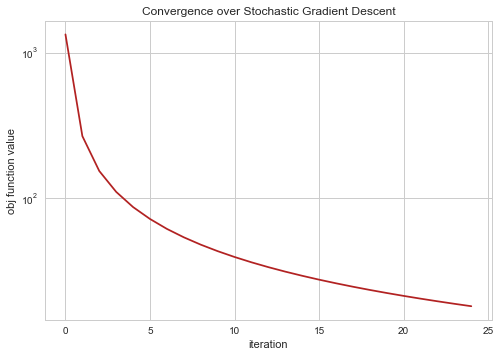

In [33]:
beta, objTracker = stochGradDescent(X_train,y_train_dummy,t=1,numClass=2,numEpochs=25)

In [34]:
prediction, truth, acc = predict(X_test,y_test_dummy,2,beta)

correct = 559
total = 625


In [35]:
acc

0.8944

---
<img src="https://cdn.guidingtech.com/imager/media/assets/191106/Best-HD-Wallpapers-From-the-Marvel-Universe_3-2_4d470f76dc99e18ad75087b1b8410ea9.jpg?1524147633" style="width: 5000px; height: 400px">
### Multiclass Classification:  Candidate Prediction from Vectorized Text

In [37]:
biden_tweets = tweet_miner.mine_user_tweets(user='JoeBiden',max_pages=75)
warren_tweets = tweet_miner.mine_user_tweets(user='ewarren',max_pages=75)
kamala_tweets = tweet_miner.mine_user_tweets(user='KamalaHarris',max_pages=75)
buttigieg_tweets = tweet_miner.mine_user_tweets(user='PeteButtigieg',max_pages=75)
yang_tweets = tweet_miner.mine_user_tweets(user='AndrewYang',max_pages=75)

In [38]:
df = pd.DataFrame(trump_tweets + bernie_tweets + biden_tweets + warren_tweets + kamala_tweets  + buttigieg_tweets + yang_tweets)

In [39]:
df['handle'].unique()

array([u'Donald J. Trump', u'Bernie Sanders', u'Joe Biden',
       u'Elizabeth Warren', u'Kamala Harris', u'Pete Buttigieg',
       u'Andrew Yang'], dtype=object)

In [40]:
tweet_text = df['text'].values
clean_text = [preprocess_text(x, fix_unicode=True, lowercase=True, transliterate=False,
                              no_urls=True, no_emails=True, no_phone_numbers=True, no_currency_symbols=True,
                              no_punct=True, no_accents=True)
              for x in tweet_text]

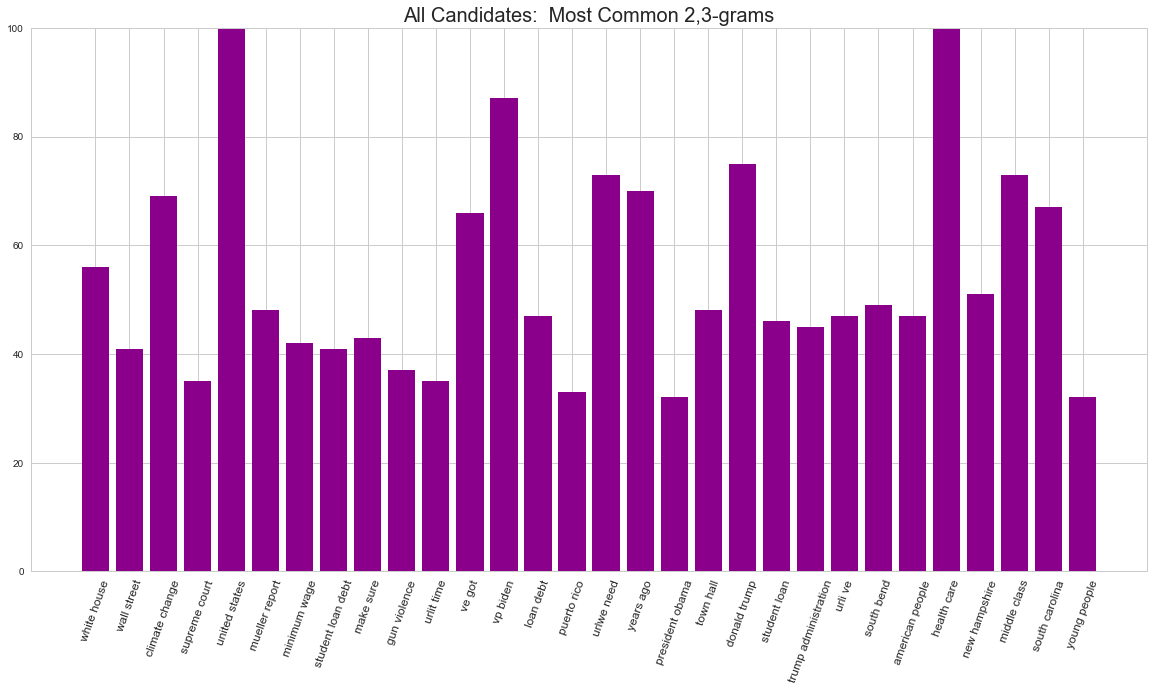

In [41]:
vect = TfidfVectorizer(ngram_range=(2,3),stop_words='english')

summaries = "".join(clean_text)
ngrams_summaries = vect.build_analyzer()(summaries)

mc = Counter(ngrams_summaries).most_common(30)

D = dict(mc)

plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center',color='darkmagenta')
plt.xticks(range(len(D)), list(D.keys()),rotation=70,size=12)
plt.ylim((0,100))
plt.title("All Candidates:  Most Common 2,3-grams",size=20)
plt.show()

### Joe Biden

In [42]:
pd.set_option('display.max_colwidth', 75)
df[df['handle'] == 'Joe Biden']['text'][:25]

2083    Earlier this week, @DrBiden,@RepRichmond, and I had the opportunity to ...
2084    The marine transit system in Alaska is vital to rural communities—but f...
2085    Trump is fighting tooth &amp; nail to deny those fleeing dangerous situ...
2086    Trump’s tariff war with China is crushing American farmers. It's easy t...
2087    Let's call Trump’s travel ban what it is: a disgrace. We are a nation o...
2088    Because a union fought for their private health insurance plan, Marcy a...
2089    Like so many other Americans, Marcy prefers to keep her private insuran...
2090    Since 1973, over 160 individuals in this country have been sentenced to...
2091    Had the opportunity to discuss my plans to advance equity and opportuni...
2092    Governor @RicardoRossello’s resignation is a testament to the power of ...
2093    The black agenda is America’s agenda. This morning, I discussed my plan...
2094    Here’s the deal: health care is a right. Every American should have the...
2095

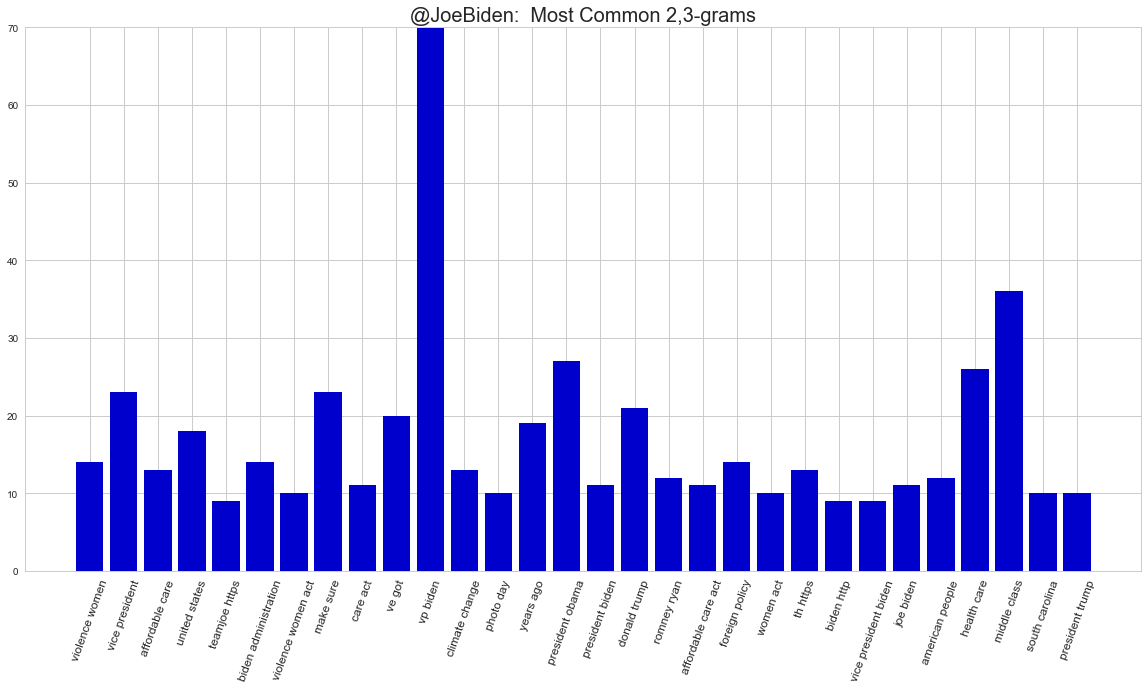

In [43]:
summaries = "".join(df['text'][df['handle']=='Joe Biden'])
ngrams_summaries = vect.build_analyzer()(summaries)

biden_mc = Counter(ngrams_summaries).most_common(30)

D = dict(biden_mc)

plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center',color='mediumblue')
plt.xticks(range(len(D)), list(D.keys()),rotation=70,size=12)
plt.ylim(0,70)
plt.title("@JoeBiden:  Most Common 2,3-grams",size=20)
plt.show()

### Elizabeth Warren 

In [44]:
df[df['handle'] == 'Elizabeth Warren']['text'][:25]

3370    A person’s HIV status has no bearing on their ability to parent. This i...
3371    This is a big win for women who work in politics and for their families...
3372    The ADA is about civil rights, opportunity, and our values—but there’s ...
3373    That changed with the passage of the ADA—which came about thanks to act...
3374    On the 29th anniversary of the Americans with Disabilities Act, I’m thi...
3375    The playing field is tilted against entrepreneurs and small business ow...
3376    HBCUs have always had to do more with less. Many are in danger of closi...
3377                                                @WendyENThomas Wow! I love it.
3378    For black moms in particular, this maternal mortality crisis is an epid...
3379    We have the power to prevent these deaths. We need paid leave so that n...
3380    I’m running a different kind of campaign. Since I don’t spend my time a...
3381    Trump's Department of Justice just approved @TMobile and @Sprint’s $26 ...
3382

<img src="https://pbs.twimg.com/profile_banners/357606935/1549675771/1500x500">

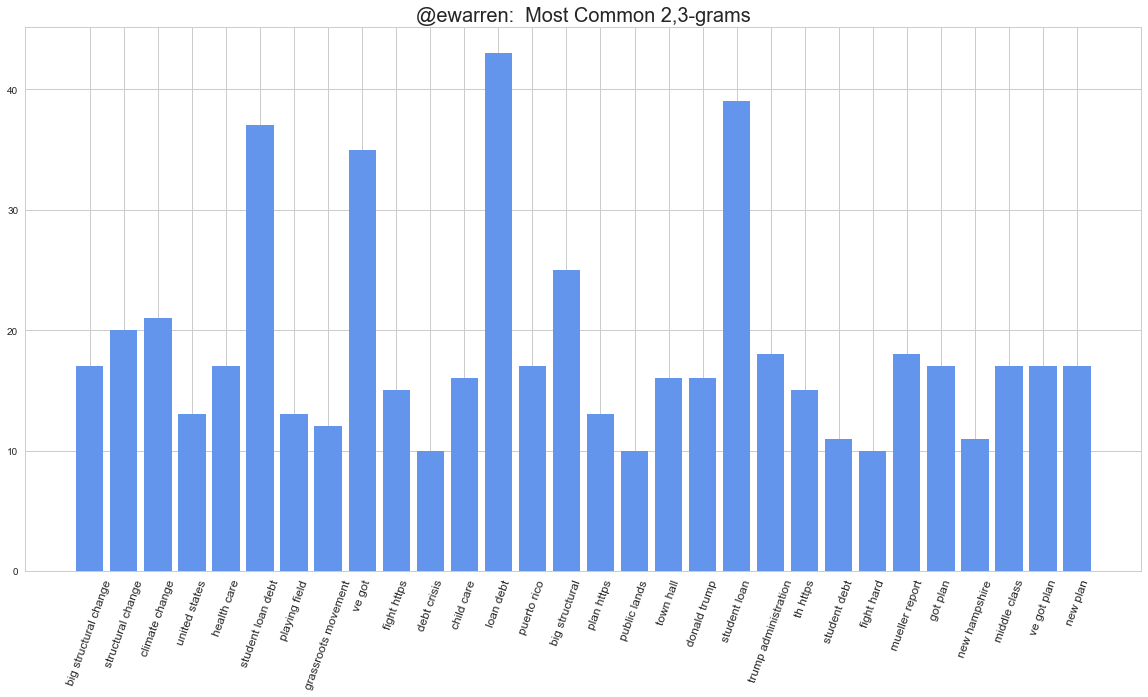

In [45]:
summaries = "".join(df['text'][df['handle']=='Elizabeth Warren'])
ngrams_summaries = vect.build_analyzer()(summaries)

warren_mc = Counter(ngrams_summaries).most_common(30)

D = dict(warren_mc)

plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center',color='cornflowerblue')
plt.xticks(range(len(D)), list(D.keys()),rotation=70,size=12)
plt.title("@ewarren:  Most Common 2,3-grams",size=20)
plt.show()

### Kamala Harris

In [46]:
df[df['handle'] == 'Kamala Harris']['text'][:25]

4713    On her @Spotify podcast, @jemelehill asked me, “Do you think Donald Tru...
4714    When elected president, I’ll invest $12 billion in Black entrepreneurs ...
4715    Parents shouldn’t have to buy a bulletproof backpack for their child ju...
4716    Trump tells people to go back to where they came from. We're not going ...
4717    More than 4 in 5 Native American and Alaska Native women have experienc...
4718    Today I’m excited to announce that as president, I will invest more tha...
4719    Congratulations, @lilmsg14! Thrilled to have you on the team fighting #...
4720    Twenty-nine years ago, the Americans with Disabilities Act was signed i...
4721    Health equity for Black women can only happen if we address persistent ...
4722    As president, I will give Congress 100 days to get their act together a...
4723    With @ricardorossello's resignation, Puerto Rico can now begin to move ...
4724    Sov and his wife Jessica received a bill for over $540K for dialysis ca...
4725

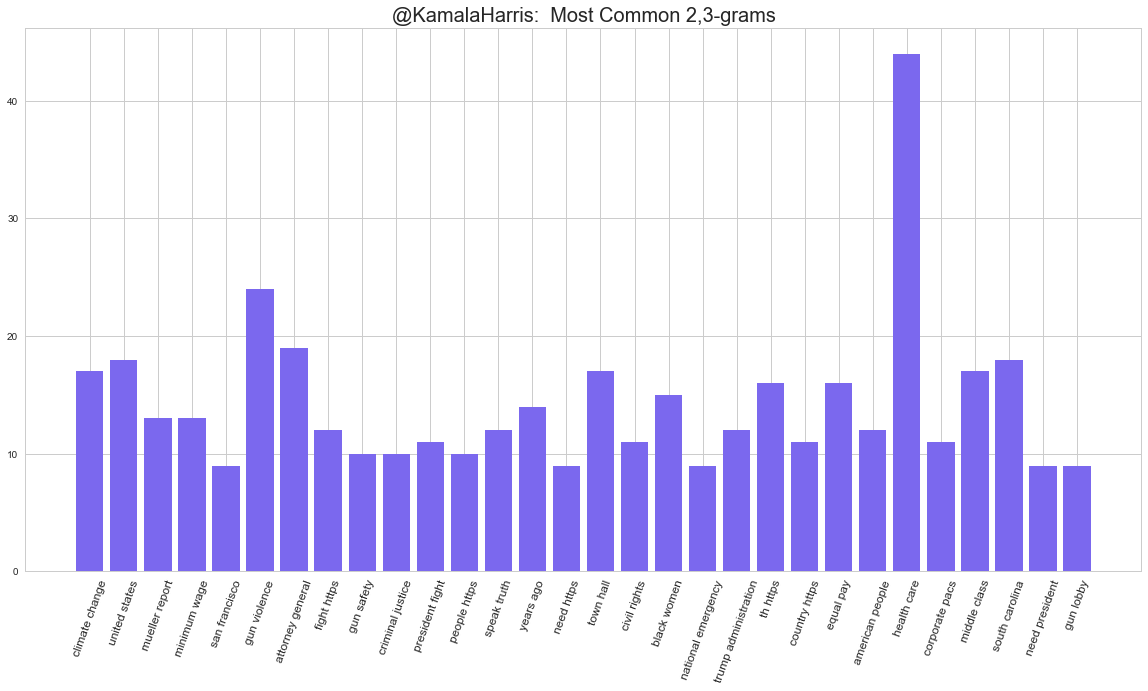

In [47]:
summaries = "".join(df['text'][df['handle']=='Kamala Harris'])
ngrams_summaries = vect.build_analyzer()(summaries)

kamala_mc = Counter(ngrams_summaries).most_common(30)

D = dict(kamala_mc)

plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center',color='mediumslateblue')
plt.xticks(range(len(D)), list(D.keys()),rotation=70,size=12)
plt.title("@KamalaHarris:  Most Common 2,3-grams",size=20)
plt.show()

### Pete Buttigieg

In [48]:
df[df['handle'] == 'Pete Buttigieg']['text'][:25]

6102                                                 Amen. https://t.co/JkNvmomzBc
6103    Hospital workers are on the front lines of patient care. I stand with t...
6104    Tune in now to watch live as Mayor Pete discusses his new policy propos...
6105    Today I'm proud to announce a new plan that will empower all workers, l...
6106    Happy #NationalInternDay indeed! Thankful for the hard work (and creati...
6107    @manuel_bonder America is stronger because we are a nation of immigrant...
6108    Justice is not equally distributed in our country. Too often, race and ...
6109    @LCJ2077 Just for the record, very grateful for @TSA workers keeping us...
6110    @cincy_4 Nope, you got it right. Not a moment to lose meeting voters wh...
6111    I'm about to take the stage at the @NAACP's 110th Annual Convention. Tu...
6112     Thanks for the amazing welcome and a great event! https://t.co/9HwNYlTVA1
6113    If we’re serious about national security, we’re going need a president ...
6114

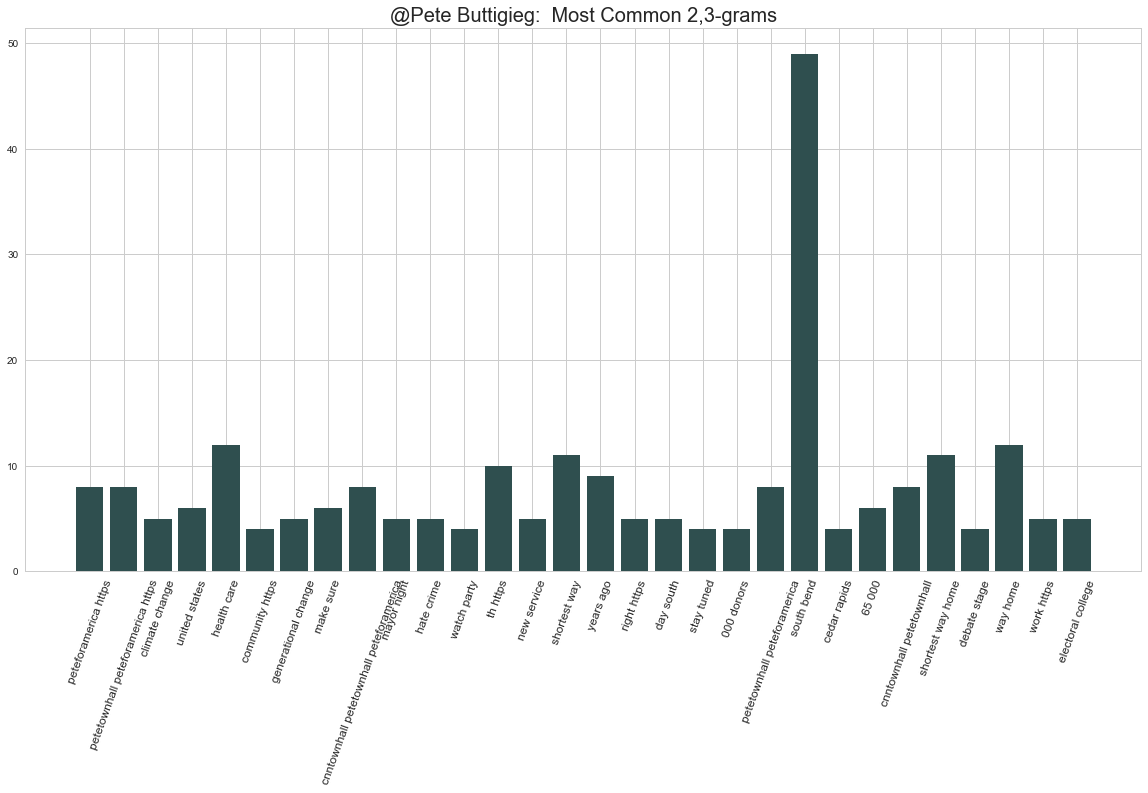

In [49]:
summaries = "".join(df['text'][df['handle']=='Pete Buttigieg'])
ngrams_summaries = vect.build_analyzer()(summaries)

buttigieg_mc = Counter(ngrams_summaries).most_common(30)

D = dict(buttigieg_mc)

plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center',color='darkslategray')
plt.xticks(range(len(D)), list(D.keys()),rotation=70,size=12)
plt.title("@Pete Buttigieg:  Most Common 2,3-grams",size=20)
plt.show()

### Andrew Yang

In [50]:
df[df['handle'] == 'Andrew Yang']['text'][:25]

7023    I’d make financial literacy a national priority and provide free financ...
7024    For 29 years Americans with disabilities have had a greater sense of di...
7025                                              @juju_faragher Thank you Juan 👍
7026    The skills and experience that our veterans gain during their service s...
7027    If I only get 3 minutes of talking time in the next debate I'm still us...
7028    American people getting our fair share of data and AI driven wealth see...
7029                                                       https://t.co/LpiKeQxNRG
7030    I would like to signal to the press that I will be attacking Michael Be...
7031    You know the feeling you have where you think “I could do a better job ...
7032    Tons of #YangGang at @TheDailyShow tonight - thank you!!!  You all are ...
7033                                                         @khoantum Thank you!!
7034                                 @CarrieA54745309 Thank you Carrie Anne!  😀👍
7035   

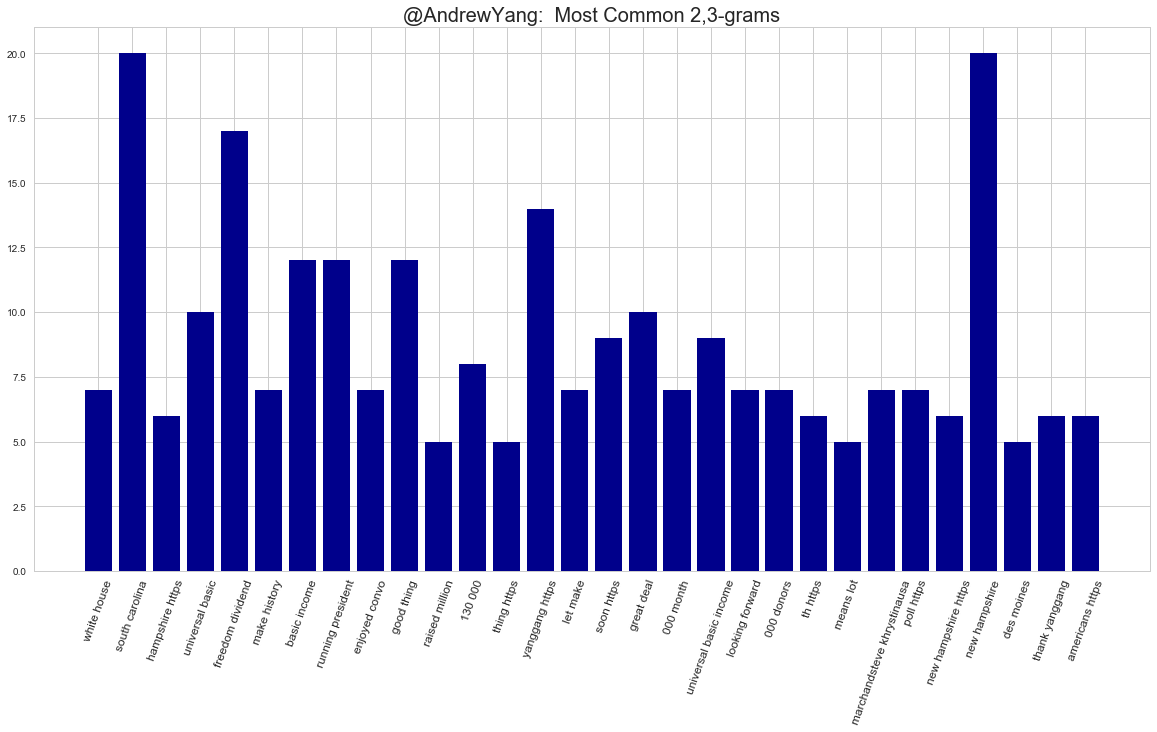

In [51]:
summaries = "".join(df['text'][df['handle']=='Andrew Yang'])
ngrams_summaries = vect.build_analyzer()(summaries)

yang_mc = Counter(ngrams_summaries).most_common(30)

D = dict(yang_mc)

plt.figure(figsize=(20,10))
plt.bar(range(len(D)), list(D.values()), align='center',color='darkblue')
plt.xticks(range(len(D)), list(D.keys()),rotation=70,size=12)
plt.title("@AndrewYang:  Most Common 2,3-grams",size=20)
plt.show()

In [52]:
# Instantiating the vectorizer to be used for modeling
vect = TfidfVectorizer(ngram_range=(1,3),stop_words='english', max_features=2500)

# Creating X matrix -- a vectorized version of the clean text
X = vect.fit_transform(clean_text).todense()
X.shape

(8282, 2500)

In [53]:
# Creating y matrix -- 0 if the tweet is by Trump, 1 if Bernie, etc.
y = df['handle'].map(lambda x: 0 if x == 'Donald J. Trump' 
                     else 1 if x == 'Bernie Sanders' 
                     else 2 if x == 'Joe Biden' 
                     else 3 if x == 'Elizabeth Warren' 
                     else 4 if x == 'Kamala Harris' 
                     else 5 if x == 'Pete Buttigieg'
                     else 6).values

df['handle'].value_counts()

Kamala Harris       1389
Elizabeth Warren    1343
Joe Biden           1287
Andrew Yang         1259
Bernie Sanders      1054
Donald J. Trump     1029
Pete Buttigieg       921
Name: handle, dtype: int64

In [54]:
logistic = LogisticRegression()
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
accuracies = cross_val_score(LogisticRegression(), X, y, cv=10)

print accuracies
print np.mean(accuracies)

[ 0.4801444   0.49277108  0.50240964  0.51628468  0.5205314   0.55917874
  0.52777778  0.63361548  0.60580411  0.58737864]
0.542589595992


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
rf = RandomForestClassifier(n_estimators=300, verbose=1)
knn = KNeighborsClassifier(n_neighbors=15)

rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.0min finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [58]:
# Random forest and K-nearest neighbor scores:
print 'RF:', rf.score(X_test, y_test)
print 'KNN:', knn.score(X_test, y_test)

RF:

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.3s finished


 0.529175050302
KNN: 0.159758551308


In [59]:
y_train_dummy = pd.get_dummies(y_train).values.tolist()
y_test_dummy = pd.get_dummies(y_test).values.tolist()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24


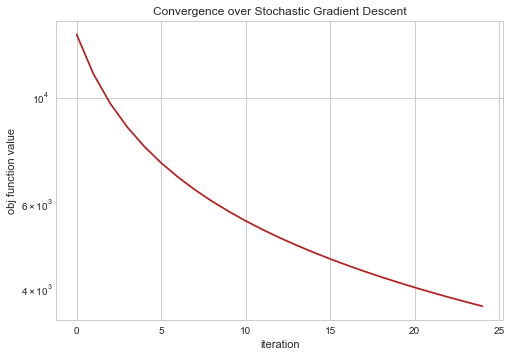

In [60]:
beta, objTracker = stochGradDescent(X_train,y_train_dummy,t=.1,numClass=7,numEpochs=25)

In [61]:
prediction, truth, acc = predict(X_test,y_test_dummy,7,beta)

correct = 1352
total = 2485


In [62]:
acc

0.5440643863179074

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define the kind of model we will building
model = Sequential()

# Create a series of dense layers
model.add(Dense(50, activation='relu', input_dim=2500))
model.add(Dropout(.25))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(7, activation='softmax'))

Using TensorFlow backend.


In [64]:
# create the loss function and optimization 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model 
history = model.fit(x=X_train, y=y_train_dummy, validation_data=[X_test, y_test_dummy], epochs=5)

Train on 5797 samples, validate on 2485 samples
Epoch 1/5
5797/5797 [==============================] - 1s - loss: 1.9077 - acc: 0.2358 - val_loss: 1.7980 - val_acc: 0.3875
Epoch 2/5
5797/5797 [==============================] - 1s - loss: 1.5693 - acc: 0.4528 - val_loss: 1.4025 - val_acc: 0.5352
Epoch 3/5
5797/5797 [==============================] - 1s - loss: 1.1771 - acc: 0.6027 - val_loss: 1.2651 - val_acc: 0.5634
Epoch 4/5
5797/5797 [==============================] - 1s - loss: 0.9494 - acc: 0.6897 - val_loss: 1.2309 - val_acc: 0.5666
Epoch 5/5
5797/5797 [==============================] - 1s - loss: 0.8015 - acc: 0.7283 - val_loss: 1.2479 - val_acc: 0.5602


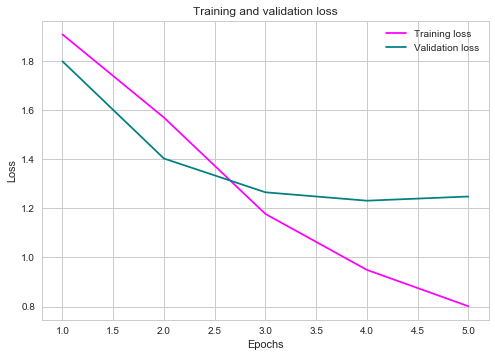

In [65]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b',label = 'Training loss',color="magenta")
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss',color="teal")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [67]:
def predict_candidate():
    random_idx = np.random.randint(X.shape[0])
    print('Tweet: ' + tweet_text[random_idx])
    print('Candidate Probabilities\n' + str(model.predict(X[random_idx])))
    cdt = np.argmax(model.predict(X[random_idx])) 
    if cdt == 0: print 'Prediction: Donald J. Trump'
    elif cdt == 1: print 'Prediction: Bernie Sanders'
    elif cdt == 2: print 'Prediction: Joe Biden'
    elif cdt == 3: print 'Prediction: Elizabeth Warren'
    elif cdt == 4: print 'Prediction: Kamala Harris'
    elif cdt == 5: print 'Prediction: Pete Buttigieg'
    else: print 'Prediction: Andrew Yang'
    print 'Actual: ' + df.iloc[random_idx]['handle'] + '\n'
        

In [68]:
for i in range(50):
    predict_candidate()

Tweet: To be fair, this is hardly unique to our state. But most states have some kind of offsetting incentive to encourage… https://t.co/d37zKOVgvE
Candidate Probabilities
[[ 0.20184019  0.28133899  0.07643791  0.04278554  0.04515151  0.26047799
   0.09196778]]
Prediction: Bernie Sanders
Actual: Pete Buttigieg

Tweet: The House just voted to move forward with raising the minimum wage to $15 an hour. It’s time we give Americans the… https://t.co/JENfe3HBKd
Candidate Probabilities
[[ 0.00738629  0.77345419  0.0469586   0.00859705  0.08624499  0.04071142
   0.03664753]]
Prediction: Bernie Sanders
Actual: Kamala Harris

Tweet: Trump lied about his motivations, and five justices called him on it. His proposal to add a citizenship question to… https://t.co/FTXltSLjfD
Candidate Probabilities
[[ 0.19175704  0.58649468  0.01414335  0.03540699  0.04485219  0.05436393
   0.07298177]]
Prediction: Bernie Sanders
Actual: Bernie Sanders

Tweet: My heart is with the people of Hong Kong as they fight f

    7.43650258e-01   8.28354619e-03   4.35741944e-03]]
Prediction: Kamala Harris
Actual: Kamala Harris

Tweet: The people that Ice will apprehend have already been ordered to be deported. This means that they have run from the… https://t.co/x6RAdp8dfv
Candidate Probabilities
[[ 0.31788218  0.12678631  0.01383373  0.07293336  0.10501205  0.11340151
   0.25015083]]
Prediction: Donald J. Trump
Actual: Donald J. Trump

Tweet: I’ve met too many teachers who are working 2-3 jobs, who stay up late worrying about how they’re going to pay the b… https://t.co/TtPpL28L9H
Candidate Probabilities
[[ 0.00339566  0.11539323  0.31772834  0.03805949  0.3965559   0.08310895
   0.04575842]]
Prediction: Kamala Harris
Actual: Kamala Harris

Tweet: Stoning people to death for homosexuality or adultery is appalling and immoral. Every single person on earth is ent… https://t.co/JXWAPfDPji
Candidate Probabilities
[[ 0.01618802  0.11504427  0.48839965  0.01065457  0.10979448  0.24779193
   0.01212711]]
Predicti